In [24]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# os.getcwd()
file_path = os.path.join(os.pardir, 'data', 'used_car_prices', 'Used_Car_Dataset.csv')
# os.listdir(file_path)

Dataset: https://www.kaggle.com/datasets/kenz32/indian-used-car-dataset


Quick read on understanding Horsepower and Torque
https://www.wkcdjrsedalia.com/research/basics-horsepower-torque.htm

In [26]:
#Read in data
df = pd.read_csv(file_path)

# Drop the first column
df = df.iloc[:,1:]

## engine(cc) and maxpower(bhp) are exactly the same
###verify
# (df['engine(cc)']!=df['max_power(bhp)']).sum()
df = df.drop('engine(cc)', axis=1)

# Drop missing values
df = df.dropna(how='any')

df.columns = ['car_name', 'registration_year', 'insurance_validity', 'fuel_type',
       'seats', 'kms_driven', 'ownership', 'transmission',
       'manufacturing_year', 'mileage_kmpl', 'max_power_bhp', 'torque_Nm',
       'price_lakhs']

# remove rows with garbage values in ownership column
df = df[df.ownership.str.contains('Owner')]

## Price, mileage, power and torque all of which have outliers
## Will remove records with values above 99th percentile
kms_driven_99 = np.quantile(df['kms_driven'], 0.99)
# mileage_kmpl_95 = np.quantile(df['mileage_kmpl'], 0.95)
## mileage has some data issues with certain cars. Mileage cannot be > 30. So for now we will drop mileage above 50 mpl
max_power_bhp_99 = np.quantile(df['max_power_bhp'], 0.99)
torque_Nm_99 = np.quantile(df['torque_Nm'], 0.99)
price_99 = np.quantile(df['price_lakhs'], 0.99)

df = df[df['kms_driven'] <= kms_driven_99]
# df = df[df['mileage_kmpl'] <= mileage_kmpl_95]
df = df[df['mileage_kmpl'] <= 30]
df = df[df['max_power_bhp'] <= max_power_bhp_99]
df = df[df['torque_Nm'] <= torque_Nm_99]
df = df[df['price_lakhs'] <= price_99]

# Convert registration_year to date
df['registration_year_6'] = pd.to_datetime(df.registration_year, format='%b-%y', errors='coerce')
df['registration_year_4'] = pd.to_datetime(df.registration_year, format='%Y', errors='coerce')
df['registration_year'] = df['registration_year_6'].combine_first(df['registration_year_4'])
df = df.drop(['registration_year_6', 'registration_year_4'], axis=1)

# Convert manufacturing_year to date
df['manufacturing_year'] = pd.to_datetime(df.manufacturing_year, format='%Y', errors='coerce')

# extracting Car manufacturer name (partial)
df['manuf'] = df.car_name.map(lambda x: x.strip().split()[1])

# computing num months used. For ownership==First Owner, we use date of registration, else year of manufacture
latest_dt = df.registration_year.max()
df['mnths_used'] =  np.where(df.ownership == 'First Owner', latest_dt-df.registration_year, latest_dt-df.manufacturing_year)
df['mnths_used'] = df['mnths_used'].dt.days
df['mnths_manf'] = latest_dt - df.manufacturing_year
df['mnths_manf'] = df['mnths_manf'].dt.days

# Select categorical and quantitative variables only
df = df.iloc[:,np.r_[2:8, 9:15]]

# splitting the data set into testing and training datasets
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Splitting apart the dependent and independent variables
# df_X_train = df_train.iloc[:,df_train.columns!='price_lakhs']
df_X_train = df_train.drop('price_lakhs', axis=1)
df_y_train = df_train['price_lakhs']
df_X_test = df_test.drop('price_lakhs', axis=1)
df_y_test = df_test['price_lakhs']

# Separating out the numeric and categorical variables in the dataframe
df_num = df_X_train.select_dtypes(include=[np.number])
df_cat = df_X_train.select_dtypes(include=[object])

In [27]:
# df.info()
# df.head()
# df.describe()

In [28]:
# # x_upper = np.quantile(df['price(in lakhs)'], 0.99)

# g = sns.displot(data=df
#             , x='price_lakhs'
#             , kind='hist', kde=True
# #             , facet_kws={'xlim':(0,x_upper)}    
#             )

In [29]:
# sns.pairplot(df)

In [71]:
## Creating pipelines for transforming the dataset

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer

# num_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False))
#                         , ('std_scaler', StandardScaler())
#                         ,])
num_pipeline = Pipeline([('std_scaler', StandardScaler())
                        ,])

cat_pipeline = Pipeline([('1hot_encoder', OneHotEncoder())
                        ,])

full_pipeline = ColumnTransformer([
    ('num_pipeline', num_pipeline, list(df_num.columns))
    , ('cat_pipeline', cat_pipeline, list(df_cat.columns))
])

In [72]:
full_pipeline.fit(df_X_train)
df_X_train_prepared = full_pipeline.transform(df_X_train)

In [73]:
# full_pipeline.get_params()
full_pipeline.get_feature_names_out()
# full_pipeline.feature_names_in_

array(['num_pipeline__seats', 'num_pipeline__kms_driven',
       'num_pipeline__mileage_kmpl', 'num_pipeline__max_power_bhp',
       'num_pipeline__torque_Nm', 'num_pipeline__mnths_used',
       'cat_pipeline__insurance_validity_Comprehensive',
       'cat_pipeline__insurance_validity_Not Available',
       'cat_pipeline__insurance_validity_Third Party',
       'cat_pipeline__insurance_validity_Third Party insurance',
       'cat_pipeline__insurance_validity_Zero Dep',
       'cat_pipeline__fuel_type_CNG', 'cat_pipeline__fuel_type_Diesel',
       'cat_pipeline__fuel_type_Petrol',
       'cat_pipeline__ownership_Fifth Owner',
       'cat_pipeline__ownership_First Owner',
       'cat_pipeline__ownership_Second Owner',
       'cat_pipeline__ownership_Third Owner',
       'cat_pipeline__transmission_Automatic',
       'cat_pipeline__transmission_Manual', 'cat_pipeline__manuf_Audi',
       'cat_pipeline__manuf_BMW', 'cat_pipeline__manuf_Datsun',
       'cat_pipeline__manuf_Fiat', 'cat_pipel

In [74]:
# try training a linear regression model

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(df_X_train_prepared, df_y_train)

LinearRegression()

In [75]:
# predict values from trained model

y_preds_lin_reg = lin_reg.predict(df_X_train_prepared)

In [76]:
# use performance metrics to measure model performance

from sklearn.metrics import mean_squared_error

lin_reg_mse = mean_squared_error(df_y_train, y_preds_lin_reg)
lin_reg_rmse = np.sqrt(lin_reg_mse)
lin_reg_r2 = lin_reg.score(df_X_train_prepared, df_y_train) # Co-efficient of determination (R^2)

lin_reg_rmse

8.421867383186417

In [77]:
dict(zip(full_pipeline.get_feature_names_out(), lin_reg.coef_))

{'num_pipeline__seats': 1.036520810452059,
 'num_pipeline__kms_driven': -1.198653958828525,
 'num_pipeline__mileage_kmpl': -1.0945418925831725,
 'num_pipeline__max_power_bhp': 2.840062603520709,
 'num_pipeline__torque_Nm': 0.1746239798836712,
 'num_pipeline__mnths_used': -3.3542719673384056,
 'cat_pipeline__insurance_validity_Comprehensive': 1.5826223234952774,
 'cat_pipeline__insurance_validity_Not Available': -8.161844674611885,
 'cat_pipeline__insurance_validity_Third Party': 4.406098742646673,
 'cat_pipeline__insurance_validity_Third Party insurance': 2.0376429636031945,
 'cat_pipeline__insurance_validity_Zero Dep': 0.13548064486399233,
 'cat_pipeline__fuel_type_CNG': 0.02487031841685199,
 'cat_pipeline__fuel_type_Diesel': -0.03591071979514798,
 'cat_pipeline__fuel_type_Petrol': 0.011040401377829065,
 'cat_pipeline__ownership_Fifth Owner': -8.161844674611885,
 'cat_pipeline__ownership_First Owner': 3.643222135839036,
 'cat_pipeline__ownership_Second Owner': 3.56383940521382,
 'cat_

In [78]:
from sklearn.linear_model import Lasso

lin_reg_lasso = Lasso(alpha=0.0001, tol=0.0001, max_iter=10000)
lin_reg_lasso.fit(df_X_train_prepared, df_y_train)
y_preds_lin_reg_lasso = lin_reg_lasso.predict(df_X_train_prepared)

In [79]:
lin_reg_lasso_mse = mean_squared_error(df_y_train, y_preds_lin_reg_lasso)
lin_reg_lasso_rmse = np.sqrt(lin_reg_lasso_mse)
lin_reg_lasso_rmse
# lin_reg_lasso_rmse_r2 = lin_reg_lasso.score(df_X_train_prepared, df_y_train) # Co-efficient of determination (R^2)

8.421870887107412

In [80]:
dict(zip(full_pipeline.get_feature_names_out(), lin_reg_lasso.coef_))

{'num_pipeline__seats': 1.0349507484094296,
 'num_pipeline__kms_driven': -1.1994014457983537,
 'num_pipeline__mileage_kmpl': -1.096279272937858,
 'num_pipeline__max_power_bhp': 2.8398356221979926,
 'num_pipeline__torque_Nm': 0.17538942664359242,
 'num_pipeline__mnths_used': -3.3540500079746955,
 'cat_pipeline__insurance_validity_Comprehensive': 0.0,
 'cat_pipeline__insurance_validity_Not Available': -20.80224168087196,
 'cat_pipeline__insurance_validity_Third Party': 2.820922361670461,
 'cat_pipeline__insurance_validity_Third Party insurance': 0.4552550934532352,
 'cat_pipeline__insurance_validity_Zero Dep': -1.442497442444449,
 'cat_pipeline__fuel_type_CNG': 0.005423449566097038,
 'cat_pipeline__fuel_type_Diesel': -0.04220102539150184,
 'cat_pipeline__fuel_type_Petrol': -0.0,
 'cat_pipeline__ownership_Fifth Owner': -0.4097416179495998,
 'cat_pipeline__ownership_First Owner': 0.2808769480016814,
 'cat_pipeline__ownership_Second Owner': 0.20193924121535095,
 'cat_pipeline__ownership_Thi

In [81]:
from sklearn.linear_model import Ridge

lin_reg_ridge = Ridge(alpha=0.001, tol=0.0001, max_iter=10000)
lin_reg_ridge.fit(df_X_train_prepared, df_y_train)
y_preds_lin_reg_ridge = lin_reg_ridge.predict(df_X_train_prepared)

In [82]:
lin_reg_ridge_mse = mean_squared_error(df_y_train, y_preds_lin_reg_ridge)
lin_reg_ridge_rmse = np.sqrt(lin_reg_ridge_mse)
lin_reg_ridge_rmse

lin_reg_ridge_r2 = lin_reg_ridge.score(df_X_train_prepared, df_y_train)
lin_reg_ridge_r2

0.7289287449419718

In [83]:
from sklearn.tree import DecisionTreeRegressor

dtree_reg = DecisionTreeRegressor(max_depth = 4, min_samples_split=20)
# dtree_reg = DecisionTreeRegressor()
dtree_reg.fit(df_X_train_prepared, df_y_train)

y_preds_dtree_reg = dtree_reg.predict(df_X_train_prepared)

In [84]:
dtree_reg_mse = mean_squared_error(df_y_train, y_preds_dtree_reg)
dtree_reg_rmse = np.sqrt(dtree_reg_mse)
dtree_reg_rmse

dtree_reg_r2 = dtree_reg.score(df_X_train_prepared, df_y_train)
dtree_reg_r2

0.7431170614225198

In [85]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dtree_reg, df_X_train_prepared, df_y_train
                        , scoring="neg_mean_squared_error", cv=7)
-scores.mean()

83.61505192228337

In [86]:
## Grid search CV

from sklearn.model_selection import GridSearchCV

dtree_reg_gscv = DecisionTreeRegressor()

param_grid=[
    {'max_depth':[20,25,30,200,500], 'min_samples_split':[2,3,4,5,10,15,20,50,100]}
]

grid_search = GridSearchCV(dtree_reg_gscv, param_grid, scoring='neg_mean_squared_error'
                           , cv=7, return_train_score=True)  # its a bunch of models

grid_search.fit(df_X_train_prepared, df_y_train)



GridSearchCV(cv=7, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [20, 25, 30, 200, 500],
                          'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 50,
                                                100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [88]:
dtree_reg_best = grid_search.best_estimator_
y_preds_dtree_reg_best = dtree_reg_best.predict(df_X_train_prepared)

In [89]:
pd.DataFrame(zip(full_pipeline.get_feature_names_out(), dtree_reg_best.feature_importances_), columns=['feat','imp'])\
            .sort_values('imp', ascending=False)

,feat,imp
3,num_pipeline__max_power_bhp,5.713890e-01
1,num_pipeline__kms_driven,1.487232e-01
5,num_pipeline__mnths_used,9.741559e-02
4,num_pipeline__torque_Nm,9.318895e-02
31,cat_pipeline__manuf_Land,3.049901e-02
2,num_pipeline__mileage_kmpl,2.751101e-02
0,num_pipeline__seats,8.392872e-03
18,cat_pipeline__transmission_Automatic,7.471068e-03
19,cat_pipeline__transmission_Manual,6.650939e-03
9,cat_pipeline__insurance_validity_Third Party i...,2.161945e-03


In [90]:
dtree_reg_best_mse = mean_squared_error(df_y_train, y_preds_dtree_reg_best)
dtree_reg_best_rmse = np.sqrt(dtree_reg_best_mse)
dtree_reg_best_rmse

# dtree_reg_best_r2 = dtree_reg_best.score(df_X_train_prepared, df_y_train)
# dtree_reg_best_r2

0.47898734643911045

In [91]:
## generalization error on test set
df_X_test_prepared = full_pipeline.transform(df_X_test)

In [92]:
df_X_test_prepared.shape

(257, 47)

In [93]:
df_X_train_prepared.shape

(1025, 47)

In [94]:
## Linear regression
y_preds_lin_reg_test = lin_reg.predict(df_X_test_prepared)

## Lasso
y_preds_lin_reg_lasso_test = lin_reg_lasso.predict(df_X_test_prepared)

## Ridge
y_preds_lin_reg_ridge_test = lin_reg_ridge.predict(df_X_test_prepared)

## Decision Tree regressor
y_preds_dtree_best_test = dtree_reg_best.predict(df_X_test_prepared)

In [95]:
lin_reg = np.sqrt(mean_squared_error(df_y_test, y_preds_lin_reg_test))
lasso = np.sqrt(mean_squared_error(df_y_test, y_preds_lin_reg_lasso_test))
ridge = np.sqrt(mean_squared_error(df_y_test, y_preds_lin_reg_ridge_test))
dtree = np.sqrt(mean_squared_error(df_y_test, y_preds_dtree_best_test))

In [96]:
print(f'lin_reg:{lin_reg:.3f},\nlasso:{lasso:.3f},\nridge:{ridge:.3f},\ndtree:{dtree:.3f}')

lin_reg:9.720,
lasso:9.720,
ridge:9.720,
dtree:5.467


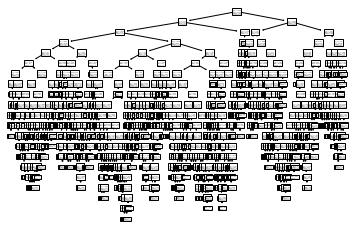

In [345]:
## Decision tree is the best predictor model
## Visualizing the trained decision tree
from sklearn import tree

tree.plot_tree(dtree_reg_best)
plt.show()

In [22]:
from sklearn.tree import export_graphviz

export_graphviz(dtree_reg_best
                , out_file = './used_car_tree.dot'
                , feature_names=full_pipeline.get_feature_names_out() 
                , rounded=True
                , filled=True
)

# dot -Tpng used_car_tree.dot -o used_car_tree.png         # to convert dot file to a png

NameError: name 'dtree_reg_best' is not defined

In [352]:
full_pipeline.get_feature_names_out()

AttributeError: 'ColumnTransformer' object has no attribute 'get_feature_names_out'

In [98]:
## try out the above models with statsmodels library

import statsmodels.api as sm

In [114]:
df_X_train_prepared

array([[-0.31112831,  0.08221871,  0.70760983, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.92650132,  0.68912422, -1.78936331, ...,  1.        ,
         0.        ,  0.        ],
       [-0.31112831, -1.6246872 , -2.20508135, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.31112831, -1.68788318,  0.06004903, ...,  0.        ,
         0.        ,  0.        ],
       [-0.31112831, -1.35006671,  0.69961525, ...,  0.        ,
         0.        ,  0.        ],
       [-0.31112831, -1.40053672, -1.42161273, ...,  0.        ,
         0.        ,  0.        ]])

In [116]:
sm_df_X_train_prepared = sm.add_constant(df_X_train_prepared.toarray(), prepend=False)

# # Fit and summarize OLS model
mod = sm.OLS(df_y_train, sm_df_X_train_prepared)

res = mod.fit()


In [117]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_lakhs   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     64.47
Date:                Sat, 06 Jan 2024   Prob (F-statistic):          4.12e-247
Time:                        16:03:22   Log-Likelihood:                -3638.5
No. Observations:                1025   AIC:                             7361.
Df Residuals:                     983   BIC:                             7568.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0365      0.371      2.791      0.005       0.308       1.765
x2            -1.1987      0.340     -3.528      0.000      -1.865      -0.532
x3            -1.0945      0.546     -2.006      0.045      -2.165      -0.024
x4             2.8401      0.572      4.961      0.000       1.717       3.963
x5             0.1746      0.312      0.560      0.576      -0.438       0.787
x6            -3.3543      0.374     -8.978      0.000      -4.087      -2.621
x7             2.5710      0.721      3.564      0.000       1.155       3.987
x8            -7.0087      2.618     -2.677      0.008     -12.147      -1.870
x9             5.3945      1.335      4.041      0.000       2.775       8.014
x10            3.0261      0.811      3.730      0.000       1.434       4.618
x11            1.1239      1.213      0.926      0.355      -1.257       3.505
x12            1.7271      2.125      0.813      0.417      -2.444       5.898
x13            1.6664      1.012      1.647      0.100      -0.319       3.652
x14            1.7133      0.981      1.747      0.081      -0.211       3.638
x15           -7.0087      2.618     -2.677      0.008     -12.147      -1.870
x16            4.9611      1.054      4.706      0.000       2.893       7.030
x17            4.8817      1.109      4.403      0.000       2.706       7.057
x18            2.2727      2.085      1.090      0.276      -1.819       6.364
x19            3.0790      0.570      5.405      0.000       1.961       4.197
x20            2.0278      0.580      3.498      0.000       0.890       3.165
x21            7.6256      1.527      4.994      0.000       4.629      10.622
x22           15.1308      1.479     10.227      0.000      12.228      18.034
x23          -10.6408      4.910     -2.167      0.030     -20.276      -1.006
x24            0.4488      8.750      0.051      0.959     -16.722      17.620
x25           -6.4040      1.884     -3.399      0.001     -10.102      -2.706
x26           -7.1526      1.113     -6.424      0.000      -9.338      -4.968
x27           -7.6241      1.038     -7.342      0.000      -9.662      -5.586
x28          -10.1654      6.011     -1.691      0.091     -21.962       1.631
x29           19.6623      2.790      7.047      0.000      14.187      25.137
x30            0.9298      2.744      0.339      0.735      -4.454       6.314
x31           -6.0940      2.080     -2.930      0.003     -10.176      -2.012
x32           25.9039      2.255     11.490      0.000      21.480      30.328
x33           45.8295      4.654      9.846      0.000      36.696      54.963
x34           -1.3220      2.514     -0.526      0.599      -6.256       3.612
x35          -11.1838      1.872     -5.974      0.000     -14.857      -7.510
x36           -7.2344      1.126     -6.422      0.000      -9.445      -5.024
x3

In [122]:
## SGD Regressor implementation
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(loss='squared_error', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15
                      , )
# dtree_reg = DecisionTreeRegressor()
sgd_reg.fit(df_X_train_prepared, df_y_train)

y_preds_sgd_reg = sgd_reg.predict(df_X_train_prepared)

In [309]:
sgd_reg_mse = mean_squared_error(df_y_train, y_preds_sgd_reg)
sgd_reg_rmse = np.sqrt(sgd_reg_mse)
sgd_reg_rmse

# sgd_reg_best_r2 = sgd_reg.score(df_X_train_prepared, df_y_train)
# sgd_reg_best_r2

8.846449283761663

In [124]:
df_X_train_prepared

<1025x47 sparse matrix of type '<class 'numpy.float64'>'
	with 11275 stored elements in Compressed Sparse Row format>

In [243]:
from numpy.linalg import inv, pinv, det, cond 

X = np.matrix(np.append(np.ones((1025,1)), df_X_train_prepared.toarray(), axis=1), dtype=np.float64)

# X_sq 
pars = X.T.dot(X).I.dot(X.T).dot(df_y_train)
# X_sq_inv = X_sq.I
# pars = X_sq_inv@X.T
# pars = pars@df_y_train

pars2 = pinv(X).dot(df_y_train)
# cond(X_sq)

# np.allclose(X_sq@X_sq_inv, np.eye(48,48))
pars.T.shape

(48, 1)

In [249]:
X.shape

(1025, 48)

In [250]:
df_X_train_prepared[1,:].toarray().shape

(1, 47)

In [251]:
y_preds_norm = X@pars.T
y_preds_norm2 = X@pars2.T

In [254]:
mean_squared_error(df_y_train, np.array(y_preds_norm2))

70.92876286032123

In [256]:
df_X_train_prepared.shape

(1025, 47)

In [314]:
theta = np.random.rand(X.shape[1],1)

lr = 0.28

for epoch in range(10_000):
    cost_func = (1/X.shape[0])*np.dot(np.square(X.dot(theta)-np.array(df_y_train).reshape(-1,1)).T, np.ones((X.shape[0],1)))
    delta_mse = (2/X.shape[0])*X.T.dot(X.dot(theta)-np.array(df_y_train).reshape(-1,1))
    theta -= lr*delta_mse
    print(np.sqrt(cost_func))

[[18.96701533]]
[[14.77664684]]
[[14.05853116]]
[[13.74649701]]
[[13.51426326]]
[[13.31452295]]
[[13.1337203]]
[[12.96599502]]
[[12.80839537]]
[[12.65928886]]
[[12.51768224]]
[[12.38290664]]
[[12.25446647]]
[[12.13196453]]
[[12.01506361]]
[[11.90346596]]
[[11.79690181]]
[[11.69512253]]
[[11.59789638]]
[[11.50500572]]
[[11.41624501]]
[[11.33141946]]
[[11.25034394]]
[[11.1728422]]
[[11.09874618]]
[[11.02789554]]
[[10.96013718]]
[[10.89532486]]
[[10.8333189]]
[[10.77398585]]
[[10.71719827]]
[[10.66283444]]
[[10.61077813]]
[[10.56091843]]
[[10.51314947]]
[[10.46737029]]
[[10.4234846]]
[[10.38140062]]
[[10.34103088]]
[[10.30229207]]
[[10.26510483]]
[[10.22939366]]
[[10.19508665]]
[[10.16211544]]
[[10.13041498]]
[[10.09992344]]
[[10.07058203]]
[[10.04233489]]
[[10.01512894]]
[[9.98891377]]
[[9.9636415]]
[[9.93926667]]
[[9.91574612]]
[[9.89303887]]
[[9.87110606]]
[[9.84991079]]
[[9.82941806]]
[[9.80959465]]
[[9.79040906]]
[[9.77183142]]
[[9.75383337]]
[[9.73638804]]
[[9.71946994]]
[[9.7030548

[[8.47974047]]
[[8.47956485]]
[[8.47938982]]
[[8.47921537]]
[[8.47904149]]
[[8.47886819]]
[[8.47869546]]
[[8.4785233]]
[[8.4783517]]
[[8.47818068]]
[[8.47801021]]
[[8.47784031]]
[[8.47767097]]
[[8.47750219]]
[[8.47733396]]
[[8.47716628]]
[[8.47699916]]
[[8.47683259]]
[[8.47666656]]
[[8.47650108]]
[[8.47633615]]
[[8.47617175]]
[[8.4760079]]
[[8.47584458]]
[[8.4756818]]
[[8.47551955]]
[[8.47535783]]
[[8.47519664]]
[[8.47503598]]
[[8.47487585]]
[[8.47471624]]
[[8.47455716]]
[[8.47439859]]
[[8.47424054]]
[[8.47408301]]
[[8.47392599]]
[[8.47376949]]
[[8.4736135]]
[[8.47345801]]
[[8.47330304]]
[[8.47314857]]
[[8.4729946]]
[[8.47284113]]
[[8.47268817]]
[[8.4725357]]
[[8.47238373]]
[[8.47223226]]
[[8.47208127]]
[[8.47193078]]
[[8.47178078]]
[[8.47163126]]
[[8.47148223]]
[[8.47133369]]
[[8.47118563]]
[[8.47103804]]
[[8.47089094]]
[[8.47074432]]
[[8.47059817]]
[[8.47045249]]
[[8.47030728]]
[[8.47016255]]
[[8.47001829]]
[[8.46987449]]
[[8.46973116]]
[[8.46958829]]
[[8.46944588]]
[[8.46930393]]
[[

[[8.42685071]]
[[8.42683823]]
[[8.42682578]]
[[8.42681337]]
[[8.42680099]]
[[8.42678864]]
[[8.42677633]]
[[8.42676405]]
[[8.4267518]]
[[8.42673959]]
[[8.4267274]]
[[8.42671525]]
[[8.42670314]]
[[8.42669105]]
[[8.426679]]
[[8.42666698]]
[[8.426655]]
[[8.42664304]]
[[8.42663112]]
[[8.42661923]]
[[8.42660737]]
[[8.42659554]]
[[8.42658375]]
[[8.42657198]]
[[8.42656025]]
[[8.42654855]]
[[8.42653688]]
[[8.42652524]]
[[8.42651363]]
[[8.42650206]]
[[8.42649051]]
[[8.426479]]
[[8.42646751]]
[[8.42645606]]
[[8.42644464]]
[[8.42643324]]
[[8.42642188]]
[[8.42641055]]
[[8.42639925]]
[[8.42638798]]
[[8.42637674]]
[[8.42636553]]
[[8.42635435]]
[[8.4263432]]
[[8.42633208]]
[[8.42632098]]
[[8.42630992]]
[[8.42629889]]
[[8.42628789]]
[[8.42627691]]
[[8.42626597]]
[[8.42625505]]
[[8.42624417]]
[[8.42623331]]
[[8.42622248]]
[[8.42621168]]
[[8.42620091]]
[[8.42619017]]
[[8.42617946]]
[[8.42616877]]
[[8.42615811]]
[[8.42614749]]
[[8.42613689]]
[[8.42612631]]
[[8.42611577]]
[[8.42610525]]
[[8.42609477]]
[[8.

[[8.42268541]]
[[8.42268358]]
[[8.42268175]]
[[8.42267993]]
[[8.42267812]]
[[8.4226763]]
[[8.42267449]]
[[8.42267269]]
[[8.42267089]]
[[8.42266909]]
[[8.4226673]]
[[8.42266551]]
[[8.42266373]]
[[8.42266195]]
[[8.42266018]]
[[8.42265841]]
[[8.42265664]]
[[8.42265488]]
[[8.42265312]]
[[8.42265136]]
[[8.42264961]]
[[8.42264787]]
[[8.42264613]]
[[8.42264439]]
[[8.42264265]]
[[8.42264092]]
[[8.4226392]]
[[8.42263748]]
[[8.42263576]]
[[8.42263405]]
[[8.42263234]]
[[8.42263063]]
[[8.42262893]]
[[8.42262723]]
[[8.42262554]]
[[8.42262385]]
[[8.42262216]]
[[8.42262048]]
[[8.4226188]]
[[8.42261713]]
[[8.42261546]]
[[8.42261379]]
[[8.42261213]]
[[8.42261047]]
[[8.42260881]]
[[8.42260716]]
[[8.42260552]]
[[8.42260387]]
[[8.42260223]]
[[8.4226006]]
[[8.42259897]]
[[8.42259734]]
[[8.42259571]]
[[8.42259409]]
[[8.42259248]]
[[8.42259086]]
[[8.42258925]]
[[8.42258765]]
[[8.42258605]]
[[8.42258445]]
[[8.42258286]]
[[8.42258126]]
[[8.42257968]]
[[8.42257809]]
[[8.42257652]]
[[8.42257494]]
[[8.42257337]]


[[8.42208696]]
[[8.42208649]]
[[8.42208603]]
[[8.42208556]]
[[8.4220851]]
[[8.42208463]]
[[8.42208417]]
[[8.42208371]]
[[8.42208325]]
[[8.42208279]]
[[8.42208233]]
[[8.42208187]]
[[8.42208141]]
[[8.42208096]]
[[8.4220805]]
[[8.42208005]]
[[8.42207959]]
[[8.42207914]]
[[8.42207869]]
[[8.42207824]]
[[8.42207779]]
[[8.42207734]]
[[8.4220769]]
[[8.42207645]]
[[8.422076]]
[[8.42207556]]
[[8.42207512]]
[[8.42207467]]
[[8.42207423]]
[[8.42207379]]
[[8.42207335]]
[[8.42207291]]
[[8.42207248]]
[[8.42207204]]
[[8.42207161]]
[[8.42207117]]
[[8.42207074]]
[[8.4220703]]
[[8.42206987]]
[[8.42206944]]
[[8.42206901]]
[[8.42206858]]
[[8.42206815]]
[[8.42206773]]
[[8.4220673]]
[[8.42206688]]
[[8.42206645]]
[[8.42206603]]
[[8.42206561]]
[[8.42206518]]
[[8.42206476]]
[[8.42206434]]
[[8.42206393]]
[[8.42206351]]
[[8.42206309]]
[[8.42206267]]
[[8.42206226]]
[[8.42206185]]
[[8.42206143]]
[[8.42206102]]
[[8.42206061]]
[[8.4220602]]
[[8.42205979]]
[[8.42205938]]
[[8.42205897]]
[[8.42205856]]
[[8.42205816]]
[[8

[[8.42192071]]
[[8.4219206]]
[[8.42192048]]
[[8.42192037]]
[[8.42192026]]
[[8.42192015]]
[[8.42192005]]
[[8.42191994]]
[[8.42191983]]
[[8.42191972]]
[[8.42191961]]
[[8.4219195]]
[[8.42191939]]
[[8.42191928]]
[[8.42191918]]
[[8.42191907]]
[[8.42191896]]
[[8.42191885]]
[[8.42191875]]
[[8.42191864]]
[[8.42191853]]
[[8.42191843]]
[[8.42191832]]
[[8.42191822]]
[[8.42191811]]
[[8.42191801]]
[[8.4219179]]
[[8.4219178]]
[[8.42191769]]
[[8.42191759]]
[[8.42191748]]
[[8.42191738]]
[[8.42191728]]
[[8.42191717]]
[[8.42191707]]
[[8.42191697]]
[[8.42191686]]
[[8.42191676]]
[[8.42191666]]
[[8.42191656]]
[[8.42191645]]
[[8.42191635]]
[[8.42191625]]
[[8.42191615]]
[[8.42191605]]
[[8.42191595]]
[[8.42191585]]
[[8.42191575]]
[[8.42191565]]
[[8.42191554]]
[[8.42191545]]
[[8.42191535]]
[[8.42191525]]
[[8.42191515]]
[[8.42191505]]
[[8.42191495]]
[[8.42191485]]
[[8.42191475]]
[[8.42191465]]
[[8.42191456]]
[[8.42191446]]
[[8.42191436]]
[[8.42191426]]
[[8.42191417]]
[[8.42191407]]
[[8.42191397]]
[[8.42191388]]

[[8.42188062]]
[[8.4218806]]
[[8.42188057]]
[[8.42188054]]
[[8.42188052]]
[[8.42188049]]
[[8.42188046]]
[[8.42188044]]
[[8.42188041]]
[[8.42188038]]
[[8.42188036]]
[[8.42188033]]
[[8.4218803]]
[[8.42188028]]
[[8.42188025]]
[[8.42188022]]
[[8.4218802]]
[[8.42188017]]
[[8.42188014]]
[[8.42188012]]
[[8.42188009]]
[[8.42188007]]
[[8.42188004]]
[[8.42188001]]
[[8.42187999]]
[[8.42187996]]
[[8.42187994]]
[[8.42187991]]
[[8.42187989]]
[[8.42187986]]
[[8.42187983]]
[[8.42187981]]
[[8.42187978]]
[[8.42187976]]
[[8.42187973]]
[[8.42187971]]
[[8.42187968]]
[[8.42187966]]
[[8.42187963]]
[[8.42187961]]
[[8.42187958]]
[[8.42187956]]
[[8.42187953]]
[[8.42187951]]
[[8.42187948]]
[[8.42187946]]
[[8.42187943]]
[[8.42187941]]
[[8.42187938]]
[[8.42187936]]
[[8.42187933]]
[[8.42187931]]
[[8.42187929]]
[[8.42187926]]
[[8.42187924]]
[[8.42187921]]
[[8.42187919]]
[[8.42187916]]
[[8.42187914]]
[[8.42187912]]
[[8.42187909]]
[[8.42187907]]
[[8.42187904]]
[[8.42187902]]
[[8.421879]]
[[8.42187897]]
[[8.42187895]]


[[8.42187081]]
[[8.4218708]]
[[8.4218708]]
[[8.42187079]]
[[8.42187078]]
[[8.42187078]]
[[8.42187077]]
[[8.42187076]]
[[8.42187076]]
[[8.42187075]]
[[8.42187074]]
[[8.42187074]]
[[8.42187073]]
[[8.42187072]]
[[8.42187072]]
[[8.42187071]]
[[8.4218707]]
[[8.42187069]]
[[8.42187069]]
[[8.42187068]]
[[8.42187067]]
[[8.42187067]]
[[8.42187066]]
[[8.42187065]]
[[8.42187065]]
[[8.42187064]]
[[8.42187063]]
[[8.42187063]]
[[8.42187062]]
[[8.42187062]]
[[8.42187061]]
[[8.4218706]]
[[8.4218706]]
[[8.42187059]]
[[8.42187058]]
[[8.42187058]]
[[8.42187057]]
[[8.42187056]]
[[8.42187056]]
[[8.42187055]]
[[8.42187054]]
[[8.42187054]]
[[8.42187053]]
[[8.42187052]]
[[8.42187052]]
[[8.42187051]]
[[8.42187051]]
[[8.4218705]]
[[8.42187049]]
[[8.42187049]]
[[8.42187048]]
[[8.42187047]]
[[8.42187047]]
[[8.42187046]]
[[8.42187046]]
[[8.42187045]]
[[8.42187044]]
[[8.42187044]]
[[8.42187043]]
[[8.42187042]]
[[8.42187042]]
[[8.42187041]]
[[8.42187041]]
[[8.4218704]]
[[8.42187039]]
[[8.42187039]]
[[8.42187038]]
[[

[[8.4218681]]
[[8.4218681]]
[[8.4218681]]
[[8.4218681]]
[[8.42186809]]
[[8.42186809]]
[[8.42186809]]
[[8.42186809]]
[[8.42186809]]
[[8.42186809]]
[[8.42186809]]
[[8.42186808]]
[[8.42186808]]
[[8.42186808]]
[[8.42186808]]
[[8.42186808]]
[[8.42186808]]
[[8.42186808]]
[[8.42186807]]
[[8.42186807]]
[[8.42186807]]
[[8.42186807]]
[[8.42186807]]
[[8.42186807]]
[[8.42186807]]
[[8.42186806]]
[[8.42186806]]
[[8.42186806]]
[[8.42186806]]
[[8.42186806]]
[[8.42186806]]
[[8.42186806]]
[[8.42186806]]
[[8.42186805]]
[[8.42186805]]
[[8.42186805]]
[[8.42186805]]
[[8.42186805]]
[[8.42186805]]
[[8.42186805]]
[[8.42186804]]
[[8.42186804]]
[[8.42186804]]
[[8.42186804]]
[[8.42186804]]
[[8.42186804]]
[[8.42186804]]
[[8.42186804]]
[[8.42186803]]
[[8.42186803]]
[[8.42186803]]
[[8.42186803]]
[[8.42186803]]
[[8.42186803]]
[[8.42186803]]
[[8.42186802]]
[[8.42186802]]
[[8.42186802]]
[[8.42186802]]
[[8.42186802]]
[[8.42186802]]
[[8.42186802]]
[[8.42186802]]
[[8.42186801]]
[[8.42186801]]
[[8.42186801]]
[[8.42186801]]

[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186753]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.42186752]]
[[8.421867

[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186742]]
[[8.42186741]]
[[8.42186741]]
[[8.42186741]]
[[8.42186741]]
[[8.42186741]]
[[8.42186741]]
[[8.421867

[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.421867

[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.42186739]]
[[8.421867

[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
[[8.42186738]]
